In [272]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from codes import utils as cutil
from codes.models import epi
import warnings

sns.set(context="paper", style="ticks", font_scale=.65)
mpl.rc('figure', max_open_warning = 0)

## settings
bn = "Exp"
sn = 0
gn = 0

dirname_sim = f"betaNoise_{bn}_gammaNoise_{gn}_sigmaNoise_{sn}"
out_home = cutil.RESULTS / "other" / "sims" / dirname_sim
plot_dir = cutil.RESULTS / "figures" / "appendix" / "sims"
plot_dir.mkdir(exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting econometric model robustness

In [273]:
sir_dir = out_home / "SIR" / "regression"

cols_to_keep = ["Intercept", "S_min", "S_min_p3", "effect_true", "intercept_true"]

reg_res_sir = epi.load_reg_results(sir_dir)
reg_res_sir["sigma"] = [np.inf]
coeffs_sir = reg_res_sir[cols_to_keep].merge(reg_res_sir.coefficient.sum("reg_lag", skipna=False))

seir_dir = out_home / "SEIR" / "regression"
reg_res_seir = epi.load_reg_results(seir_dir)
coeffs_seir = reg_res_seir[cols_to_keep].merge(reg_res_seir.coefficient.sum("reg_lag", skipna=False))

coeffs = xr.concat([coeffs_seir, coeffs_sir], dim="sigma")
coeffs.attrs = reg_res.attrs

coeffs = coeffs.rename({
    "Intercept": "intercept",
    "effect_true": "coefficient_true"
})

# rearrange to get cum_effects in there too
new_coeffs = coeffs.drop_dims("policy").drop(["intercept", "intercept_true"]).copy()
coeffs["cum_effect"] = coeffs.coefficient.sum(dim="policy", skipna=False)
coeffs["cum_effect_true"] = coeffs.coefficient_true.sum(dim="policy", skipna=False)
new_var = coeffs[["intercept_true", "cum_effect_true"]].rename({
    "intercept_true": "intercept",
    "cum_effect_true": "cum_effect"
}).to_array(dim="policy")
coefficient_true = xr.concat((coeffs.coefficient_true, new_var), dim="policy")
new_var = coeffs[["intercept", "cum_effect"]].to_array(dim="policy")
coefficient = xr.concat((coeffs.coefficient, new_var), dim="policy")
coeffs = xr.merge((new_coeffs, coefficient, coefficient_true))

coeffs = coeffs.sortby(["sigma","pop"])

In [213]:
coeffs.sel(policy="p1")

<xarray.Dataset>
Dimensions:           (LHS: 4, gamma: 3, pop: 4, sample: 1000, sigma: 4)
Coordinates:
  * pop               (pop) int64 100000 1000000 10000000 100000000
  * gamma             (gamma) float64 0.002083 0.008333 0.01375
  * sample            (sample) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * LHS               (LHS) object 'EI' 'EIR' 'I' 'IR'
  * sigma             (sigma) float64 0.008333 0.01375 0.02083 inf
    policy            <U2 'p1'
Data variables:
    S_min             (pop, sample, gamma, sigma) float64 0.9716 ... 0.9999
    S_min_p3          (pop, sample, gamma, sigma) float64 0.9931 0.9905 ... 1.0
    coefficient       (pop, gamma, sigma, sample, LHS) float32 nan ... 0.028956674
    coefficient_true  (sigma, gamma) float64 -0.04346 -0.04482 ... -0.05324

In [274]:
def plot_factor_coeff(ds, pop, LHS_var, title="", n_bins=40, xlim=None, hist_kwargs={"edgecolor": "none"}, fig_label=None, **facet_kwargs):
    
    this_true_val = ds.coefficient_true.mean().item()
    if this_true_val > 0:
        xmin = 0
        if xlim is None:
            xmax = this_true_val * 2
        else:
            xmax = xlim
        text_ha, text_x, leg_x = ("left", .03, .4)
    elif this_true_val < 0:
        if xlim is None:
            xmin = this_true_val * 2
        else:
            xmin=-xlim
        xmax = 0
        text_ha, text_x, leg_x = ("right", .97,-.1)

    g = xr.plot.FacetGrid(ds.sel(LHS=LHS_var, pop=pop), sharey="row", **facet_kwargs)
    g.map(lambda x: plt.axvline(x, color="k", label="true"), "coefficient_true")
    for ax in g.axes.flat:
        ax.set_xlim(xmin, xmax)

    def nowarn_hist(data, *args, xmin=None, xmax=None, **kwargs):
        binmin = max(xmin, np.nanmin(data))
        binmax = min(xmax, np.nanmax(data))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return plt.hist(data, *args, bins=np.linspace(binmin, binmax, n_bins), **kwargs)

    g.map(nowarn_hist, "coefficient", xmin=xmin, xmax=xmax, **hist_kwargs)
    g.map(
        lambda x: plt.axvline(
            np.nanmedian(x), color="r", linestyle="--", label="Median\nestimate"
        ),
        "coefficient",
    )
    g.map(
        lambda x, z: plt.text(
            text_x,
            0.97,
            f"$min(S)$: {x.min().item():.2f}\nBias: {(np.nanmedian(z)-this_true_val) / this_true_val:.1%}",
            horizontalalignment=text_ha,
            verticalalignment="top",
            transform=plt.gca().transAxes,
        ),
        "S_min",
        "coefficient"
    )
    if ds.policy.item()=="intercept":
        xlabel="No-policy growth rate"
    else:
        xlabel="Growth rate effect"
    g.axes.flat[0].legend(loc=(leg_x,.2))
    g.set_xlabels(xlabel)
    g.set_titles("$\{coord} = {value}$")
    g.map(lambda: plt.yticks([]))
    if fig_label is not None:
        g.fig.text(.03, .97, fig_label, fontsize=7, fontweight='bold', va='top', ha='left')
    g.fig.subplots_adjust(top=.9)
    g.fig.suptitle(title, va="bottom", y=.95)
    sns.despine(g.fig, left=True)
    return g

In [276]:
facet_kwargs = dict(
    row="sigma",
    col="gamma"
)

for p in coeffs.pop.values:
    multipliers = ["k", "M", "B"]
    ix = 0
    p_str_val = p/1000
    while p_str_val >= 1000:
        p_str_val /= 1000
        ix += 1
    p_str_val = str(int(p_str_val))+multipliers[ix]
    for LHS in ["I", "IR"]:
        LHS_dict = {
            "I": "Active\ Cases",
            "IR": "Cumulative\ Cases"
        }
        if p==1e8 and LHS=="I":
            fig_label="a"
        elif p==1e5 and LHS=="IR":
            fig_label="b"
        else:
            fig_label=None
        title = f"Pop: {p_str_val}; Dependent Variable: $\Delta log({LHS_dict[LHS]})$"
        for var in ["intercept", "cum_effect", "p1", "p2", "p3"]:
            
            g = plot_factor_coeff(
                coeffs.sel(policy=var), 
                p, 
                LHS,
                title=title, 
                figsize=(6.5,3.25),
                fig_label=fig_label,
                xlim=0.5,
                **facet_kwargs
            )

            for suffix in ["pdf", "png"]:
                g.fig.savefig(plot_dir / f"{var}_pop_{p}_LHS_{LHS}.{suffix}", dpi=300)
            plt.clf()

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

<Figure size 468x234 with 0 Axes>

## Showing re-projection performance

In [285]:
true = xr.open_dataset(proj_dir / "true.nc")
sir = xr.open_dataset(proj_dir / "pred_sir.nc")
seir = xr.open_dataset(proj_dir / "pred_seir.nc")
true.load()
sir.load()
seir.load()

sir["cum_cases_steady_state"] = 1 - (sir.gamma_deterministic / sir.beta_deterministic.isel(t=-1))
seir["cum_cases_steady_state"] = 1 - (seir.gamma_deterministic / seir.beta_deterministic.isel(t=-1))
true["cum_cases_steady_state"] = 1 - (true.gamma / 24 / true.beta_deterministic.isel(t=-1))

full_ds = {
    "true": true,
    "sir": sir,
    "seir": seir
}

# add on cum observed cases
for k,v in full_ds.items():
    v["IR"] = v.I + v.R

FileNotFoundError: [Errno 2] No such file or directory: b'/home/bolliger/git_repos/gpl-covid/results/other/sims/betaNoise_0.08_gammaNoise_0_sigmaNoise_0/projection/true.nc'

In [3]:
means = {k:v.mean(dim="sample") for k,v in full_ds.items()}
p95 = {k:v.quantile(.95, dim="sample") for k,v in full_ds.items()}
p50 = {k:v.quantile(.5, dim="sample") for k,v in full_ds.items()}
p05 = {k:v.quantile(.05, dim="sample") for k,v in full_ds.items()}

qs = {k: xr.concat([p05[k], p50[k], p95[k]], dim="quantile") for k in p50.keys()}

In [8]:
for s_proj in qs["seir"].sigma_proj.values:
    for L in qs["seir"].LHS.values:
        this_ds = xr.concat(
            [
                qs["true"].drop("E"), 
                qs["sir"].sel(LHS=L), 
                qs["seir"].sel(LHS=L).sel(sigma_proj=s_proj).drop("E")
            ], 
            dim="model",
        )
        this_ds["model"] = ["true", "sir", "seir"]
        for p in qs["seir"].pop.values:
            
            g = xr.plot.FacetGrid(this_ds.sel(pop=p), col="gamma", row="sigma")
            colors = "rgb"
            def plot_ranges(data):
                for mx,m in enumerate(this_ds.model):
                    # get this particular model
                    this_data = data[mx]

                    # get diff in policy vs. no policy
                    this_data = this_data[:,0] - this_data[:,1]

                    # plot quantile diffs
                    if m.item()=="true":
                        alpha=1
                    else:
                        alpha=.5

                    if m.item()=="seir":
                        label = f"SEIR ($\gamma_{{proj}} = {s_proj:.2f}$)"
                    elif m.item()=="sir":
                        label = "SIR"
                    else:
                        label = "true"
                    plt.fill_between(this_ds.t.values, this_data[0], this_data[-1], label=label, color=colors[mx], alpha=alpha)
            g.map(plot_ranges, "IR")
            g.axes.flat[0].legend(loc="upper left")
            g.set_xlabels("")
            g.set_titles("$\{coord}$ = {value}")
            g.fig.suptitle(f"LHS: {L}, Pop: {p:.0g}", va="bottom", y=0.99)
            g.fig.savefig(plot_dir / f"IR_timeseries_pop_{p}_LHS_{L}_sigmaProj_{s_proj}.pdf", dpi=300)
            plt.clf()

/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/plot/facetgrid.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/plot/facetgrid.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/plot/facetgrid.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

## Endemic state values

The below plots show how the estimated difference in cumulative cases at the endemic steady state (between policy and no-policy scenarios) differs across different epi parameters and different simulation engines (SIR vs. SEIR).

In [55]:
LHS_to_plot = ["I", "IR"]

this_true = means["true"].sel(with_policy=0) - means["true"].sel(with_policy=1)
this_true = this_true.cum_cases_steady_state

seirs = []
for s_proj in means["seir"].sigma_proj:
    this_pred_seir = means["seir"].sel(with_policy=0) - means["seir"].sel(with_policy=1)
    this_pred_seir = this_pred_seir.cum_cases_steady_state.sel(sigma_proj=s_proj).drop("sigma_proj")
    seirs.append(this_pred_seir)

this_pred_sir = means["sir"].sel(with_policy=0) - means["sir"].sel(with_policy=1)
this_pred_sir = this_pred_sir.cum_cases_steady_state

plot_ds = xr.concat([this_true, this_pred_sir] + seirs, dim="model").mean("pop")
plot_ds["model"] = ["true", "SIR"] + [f"SEIR_{i:.2f}" for i in means["seir"].sigma_proj.values]

plot_ds = plot_ds.sel(LHS=LHS_to_plot)
plot_df = plot_ds.to_dataframe().reset_index(drop=False)

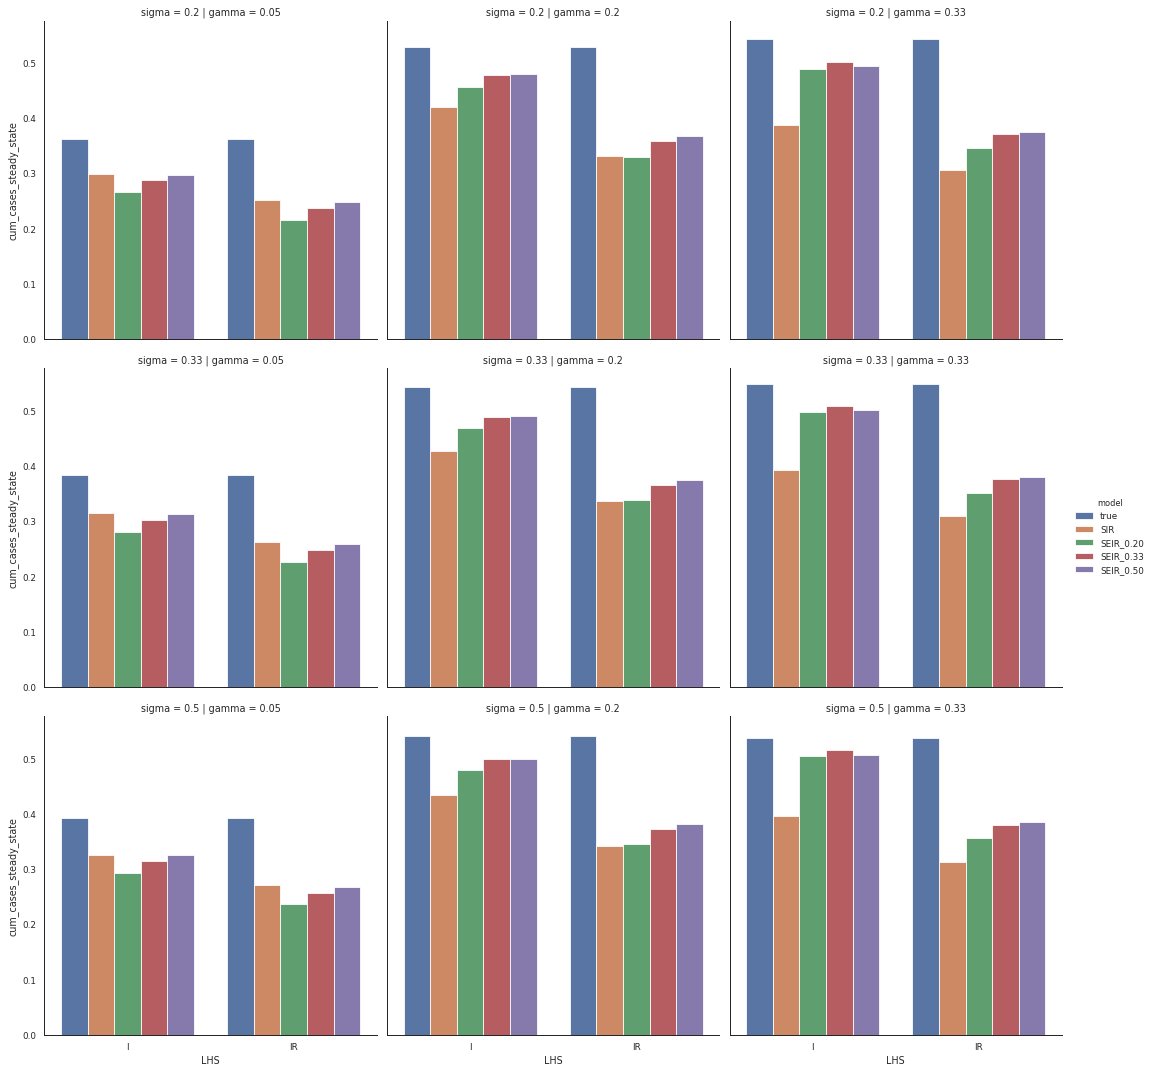

In [57]:
sns.catplot(data=plot_df, row="sigma", col="gamma", x="LHS", hue="model", y="cum_cases_steady_state", kind="bar")